<a href="https://colab.research.google.com/github/Jahnvi99/Leuphana-Intern/blob/master/Gaussian_Processes2d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gpytorch

     |████████████████████████████████| 501kB 9.3MB/s 


In [ ]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
x_0 = torch.linspace(-3, 3, 25)
x_1 = torch.linspace(-3, 3, 25)
xx, yy = torch.meshgrid(x_0, x_1) 

In [ ]:
xx.shape

torch.Size([25, 25])

In [ ]:
train_x = torch.stack((xx.ravel(), yy.ravel())).T

In [ ]:
train_x.shape

torch.Size([625, 2])

In [ ]:
train_y = (torch.sin(train_x[:,0]) + torch.cos(train_x[:,1])+torch.randn(625)*0.05)

In [ ]:
train_y.shape

torch.Size([625])

In [ ]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    
    def __init__(self, train_x, train_y, likelihood, use_ard = True):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        ard_num_dims = None
        if use_ard:
            ard_num_dims = train_x.shape[-1]
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims = train_x.shape[-1]))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [ ]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print("Iter %d/%d - Loss: %.3f   lengthscales: %.3f, %.3f   noise: %.3f" % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.squeeze()[0],
        model.covar_module.base_kernel.lengthscale.squeeze()[1],
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 0.867   lengthscales: 0.693, 0.693   noise: 0.693
Iter 2/50 - Loss: 0.845   lengthscales: 0.718, 0.718   noise: 0.669
Iter 3/50 - Loss: 0.823   lengthscales: 0.744, 0.744   noise: 0.644
Iter 4/50 - Loss: 0.801   lengthscales: 0.771, 0.771   noise: 0.621
Iter 5/50 - Loss: 0.779   lengthscales: 0.798, 0.798   noise: 0.598
Iter 6/50 - Loss: 0.757   lengthscales: 0.825, 0.825   noise: 0.576
Iter 7/50 - Loss: 0.735   lengthscales: 0.853, 0.853   noise: 0.554
Iter 8/50 - Loss: 0.713   lengthscales: 0.881, 0.882   noise: 0.533
Iter 9/50 - Loss: 0.692   lengthscales: 0.910, 0.910   noise: 0.513
Iter 10/50 - Loss: 0.670   lengthscales: 0.939, 0.940   noise: 0.493
Iter 11/50 - Loss: 0.648   lengthscales: 0.968, 0.969   noise: 0.473
Iter 12/50 - Loss: 0.626   lengthscales: 0.998, 0.999   noise: 0.455
Iter 13/50 - Loss: 0.604   lengthscales: 1.028, 1.028   noise: 0.436
Iter 14/50 - Loss: 0.582   lengthscales: 1.057, 1.058   noise: 0.419
Iter 15/50 - Loss: 0.560   lengthscales: 1.

In [ ]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x_0 = torch.linspace(-3,3,20)
    test_x_1 = torch.linspace(-3,3,20)
    test_xx, test_yy = torch.meshgrid(test_x_0, test_x_1) 
    test_x = torch.stack((test_xx.ravel(), test_yy.ravel())).T
    observed_pred = likelihood(model(test_x))

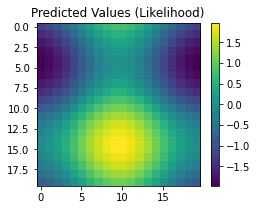

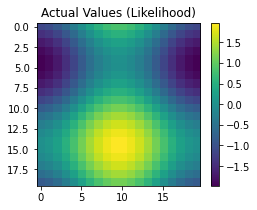

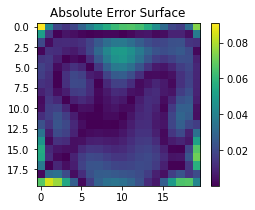

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

pred_labels = observed_pred.mean.view(20, 20)

# Calc abosolute error
test_y_actual =  (torch.sin(test_x[:,0]) + torch.cos(test_x[:,1])).view(20,20)
delta_y = torch.abs(pred_labels - test_y_actual).detach().numpy()

# Define a plotting function
def ax_plot(f, ax, y_labels, title):
    if smoke_test: return  # this is for running the notebook in our testing framework
    im = ax.imshow(y_labels)
    ax.set_title(title)
    f.colorbar(im)

# Plot our predictive means
f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
ax_plot(f, observed_ax, pred_labels, 'Predicted Values (Likelihood)')

# Plot the true values
f, observed_ax2 = plt.subplots(1, 1, figsize=(4, 3))
ax_plot(f, observed_ax2, test_y_actual, 'Actual Values (Likelihood)')

# Plot the absolute errors
f, observed_ax3 = plt.subplots(1, 1, figsize=(4, 3))
ax_plot(f, observed_ax3, delta_y, 'Absolute Error Surface')

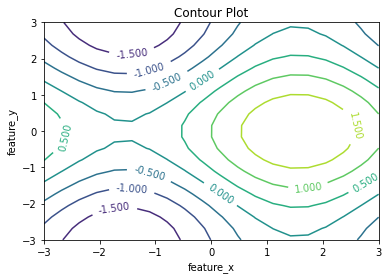

In [ ]:
pred_y = observed_pred.mean.reshape(test_xx.shape)
fig, ax = plt.subplots(1, 1)
  
# plots contour lines
CS = ax.contour(test_xx, test_yy, pred_y)
  
ax.set_title('Contour Plot')
ax.set_xlabel('feature_x')
ax.set_ylabel('feature_y')
plt.clabel(CS, inline=1, fontsize=10)  
plt.show()

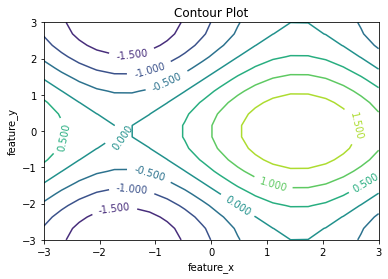

In [ ]:
test_y_actual = (torch.sin(test_x[:,0]) + torch.cos(test_x[:,1])).reshape(test_xx.shape)
fig, ax = plt.subplots(1, 1)
  
# plots contour lines
CS = ax.contour(test_xx, test_yy, test_y_actual)
  
ax.set_title('Contour Plot')
ax.set_xlabel('feature_x')
ax.set_ylabel('feature_y')
plt.clabel(CS, inline=1, fontsize=10)  
plt.show()

/usr/local/lib/python3.7/dist-packages/gpytorch/models/exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


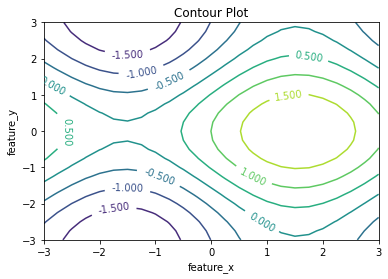

In [ ]:
observed_pred = likelihood(model(train_x))
pred_train_y = observed_pred.mean.detach().numpy().reshape(xx.shape)
fig, ax = plt.subplots(1, 1)
  
# plots contour lines
CS = ax.contour(xx, yy, pred_train_y)
  
ax.set_title('Contour Plot')
ax.set_xlabel('feature_x')
ax.set_ylabel('feature_y')
plt.clabel(CS, inline=1, fontsize=10)  
plt.show()

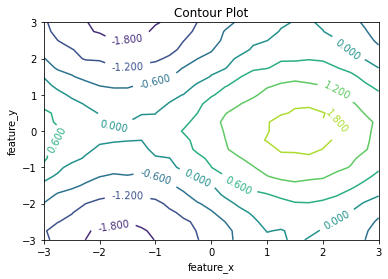

In [ ]:
train_y = train_y.reshape(xx.shape)
fig, ax = plt.subplots(1, 1)
  
# plots contour lines
CS = ax.contour(xx, yy, train_y)
  
ax.set_title('Contour Plot')
ax.set_xlabel('feature_x')
ax.set_ylabel('feature_y')
plt.clabel(CS, inline=1, fontsize=10)  
plt.show()

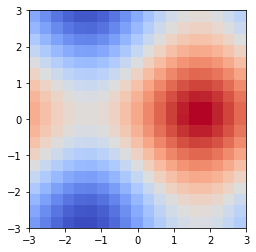

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
ax.set_aspect(1)
ax.pcolormesh(test_xx, test_yy, pred_y, cmap=plt.cm.coolwarm)
  
plt.show()

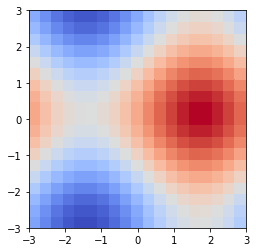

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
ax.set_aspect(1)
ax.pcolormesh(test_xx, test_yy, test_y_actual, cmap=plt.cm.coolwarm)
  
plt.show()

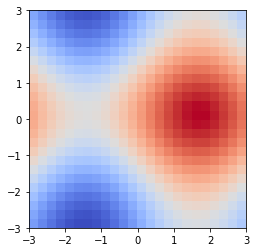

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
ax.set_aspect(1)
ax.pcolormesh(xx, yy, pred_train_y, cmap=plt.cm.coolwarm)
  
plt.show()

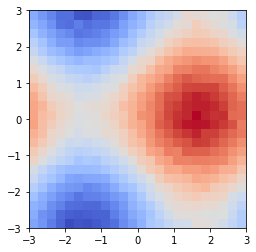

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


fig, ax = plt.subplots()
ax.set_aspect(1)
ax.pcolormesh(xx, yy, train_y, cmap=plt.cm.coolwarm)
  
plt.show()

#Some pointers

Try using a ZeroMean, rather than a constant mean. It could be that having more hyperparameters (constant mean hyperparameter values) could lead the -mll objective to a local minima, rather than to a global minima. Using a different optimizer, e.g. lbfgs (which is second-order, rather than adam or sgd, which are both first-order) may help with this as well.

Try normalizing your input data using min-max normalization, and your targets using standard normal N(0,1) normalization. In short, these normalization steps ensure that your data is consistent with the default priors for these GPR models. For more info on this, check out this GitHub issue.

Try changing the learning rate for optimizing your hyperparameters, or the number of epochs you train this for.

If you see any issues with numerical precision (particularly after normalization, if you choose to use it), try changing your model and datasets to double, 64-bit precision by converting torch tensors to double-precision tensors with tensor.double().